In [15]:
import NN_routines as nns
import torch
import os
import time
import cv2
#from tqdm.notebook import tqdm
from tqdm import tqdm
import pickle 
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from imutils import paths
from sklearn.model_selection import train_test_split

In [20]:
def dataset_produce(image,mask,name,macro = True,aug = True):
    if macro: 
        !mkdir $name
        !mkdir $name/macro
        !mkdir $name/macro/training_labels
        !mkdir $name/macro/training_data
        folder = str(name)+'/macro'
        pix = 640   
    else:
        !mkdir $name
        !mkdir $name/micro
        !mkdir $name/micro/training_labels
        !mkdir $name/micro/training_data
        folder = str(name)+'/micro'
        pix = 128
    nns.overhead_write(image,mask,pix,folder,name,aug)
  
def predict_img(name,img_path,mask_path,macro_model_state,micro_model_state,lw_path='Supply/lw_mask.png',show = True):
  startTime = time.time()               
  print('load image...')
  o_img = cv2.imread(img_path)
  if mask_path: 
    print('load mask...')
    o_mask = cv2.imread(mask_path)  
    compare = True  
  else: o_mask,compare = None,False
  o_lw = cv2.imread(lw_path,0)
  print('create macro dataset...')
  img,mask = nns.image_process(o_img,o_mask)
  dataset_produce(img,mask,name,aug = False)
  print('transfer macro prediction...')
  macro_img = nns.big_picture(macro_model_state,name,macro = True,thresh = 0.15,compare = compare,show = False,out = True)
  print('create micro dataset...')
  dataset_produce(macro_img,mask,name,macro = False,aug = False)
  print('create raw prediction...')
  micro_img = nns.big_picture(micro_model_state,name,macro = False,thresh = 0.5,compare = compare,show = False,out = True) 
  print('floodfill...')
  raw_predict = micro_img[:len(o_img),:len(o_img[0]),2]
  cv2.imwrite(name+'/raw_prediction_'+name+'.png',raw_predict)
  ff_predict = cv2.imread(name+'/raw_prediction_'+name+'.png',0)
  cv2.floodFill(ff_predict,None,(0,len(ff_predict[0])-1),128)
  ff_predict[ff_predict != 128] = 255
  ff_predict[ff_predict == 128] = 0
  cv2.imwrite(name+'/ff_prediction_'+name+'.png',ff_predict)
  if show:      
    n = 3
    if compare:  
      e_p = len(np.where(o_mask[:,:,0] != raw_predict)[0])/len(np.where(o_lw==128)[0])*100
      e_ff = len(np.where(o_mask[:,:,0] != ff_predict)[0])/len(np.where(o_lw==128)[0])*100
      n+=1

    fig, ax = plt.subplots(1,n,figsize = (30,12))
    ax[0].imshow(o_img)
    ax[0].set_title('original img',fontsize = 22)    
    ax[n-2].imshow(raw_predict,'plasma')
    ax[n-2].set_title('raw prediction',fontsize = 22)
    ax[n-1].imshow(ff_predict,'plasma')
    ax[n-1].set_title('floodfill prediction',fontsize = 22)
    if compare: 
      ax[1].imshow(o_mask)
      ax[1].set_title('original mask',fontsize = 22)    
      ax[n-2].set_title('prediction, %1.1f pc error on lw-mask'%e_p,fontsize = 22)
      ax[n-1].set_title('floodfill, %1.1f pc error on lw-mask'%e_ff,fontsize = 22)

  print('total time taken for prediction: {:.2f}s'.format(time.time()-startTime))

def training_dataset(Folder,aug = False,create_ds= True, macro_training = True,macro_epochs = 40,title = 'ma1', micro_training = True,micro_epochs = 20):
  names = []
  if create_ds:
    !mkdir Training
    !mkdir Training/macro
    !mkdir Training/macro/training_labels
    !mkdir Training/macro/training_data
    !mkdir Training/micro
    !mkdir Training/micro/training_labels
    !mkdir Training/micro/training_data
    folder = 'Training/macro'
    for file in sorted(os.listdir(Folder)):
      if file[:5] == 'image' and os.path.exists(Folder+'mask'+file[5:]):
        image,mask = image_process(cv2.imread(Folder+file),cv2.imread(Folder+'mask'+file[5:]))
        name = file[-12:-4]
        names.append(name)
        print(name+'   in process')
        overhead_write(image,mask,640,folder,name,aug)
  else:
    for file in sorted(os.listdir(Folder)):
      if file[:5] == 'image' and os.path.exists(Folder+'mask'+file[5:]):
        names.append(file[-12:-4])
  if macro_training: 
    print('macro training started')
    tLoader, vLoader = Dataloading(folder,batch_size = 16, macro = True,thresh = 0.15)                                        # build dataloader
    H,macro_result = Network_Training(tLoader,vLoader,macro_epochs,0.001,macro = True,title =title) # training execution: 20 epochs, learning rate = 0.001
    loss_propagation(H,title =title)                                       # show loss propagation
  else:
    macro_result = torch.load('Model_params/'+title+'_macro_best.pt',map_location=torch.device('cpu'))                          # load model state if no training 
  print('transfer started')
  folder = 'Training/micro'
  for name in names:    
    print(name+'   in process')
    mp_img = big_picture(macro_result,name,macro = True,thresh = 0.15,show = False,out = True,folder = 'Training')
    image,mask = image_process(cv2.imread(Folder+'image_'+name+'.png'),cv2.imread(Folder+'mask_'+name+'.png'))
    overhead_write(image,mask,128,folder,name,aug)

  if micro_training: 
    print('micro training started')
    tLoader, vLoader = Dataloading(folder,macro = False,thresh = 0.5)                                        # build dataloader
    H,micro_result = Network_Training(tLoader,vLoader,micro_epochs,0.001,macro = False,title =title) # training execution: 20 epochs, learning rate = 0.001
    loss_propagation(H,title =title)                                       # 
  else:
    micro_result = torch.load('Model_params/'+title+'_best.pt',map_location=torch.device('cpu'))
    
def clear_routine(Save):
    basic = ['Model_params', 'NN_routine.ipynb','NN_routines.py','NN_execution.ipynb', 'README.md', '.git', 'Training', 'Test', 'Supply', 'Save', 'Image_storage']
    %cd .. 
    all_directories =os.listdir('NN_water_lines')    
    %cd ./NN_water_lines
    for directory in all_directories:
        if directory not in basic and directory not in Save:
            !rm -r $directory

load image...
load mask...
create macro dataset...
mkdir: cannot create directory ‘20200108’: File exists
mkdir: cannot create directory ‘20200108/macro’: File exists
mkdir: cannot create directory ‘20200108/macro/training_labels’: File exists
mkdir: cannot create directory ‘20200108/macro/training_data’: File exists


  0%|          | 0/8 [00:00<?, ?it/s]

transfer macro prediction...


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


create micro dataset...
mkdir: cannot create directory ‘20200108’: File exists


  0%|          | 0/40 [00:00<?, ?it/s]

create raw prediction...


100%|██████████| 40/40 [04:27<00:00,  6.68s/it]


floodfill...
total time taken for prediction: 278.11s
CPU times: user 14min 59s, sys: 2.25 s, total: 15min 2s
Wall time: 4min 38s


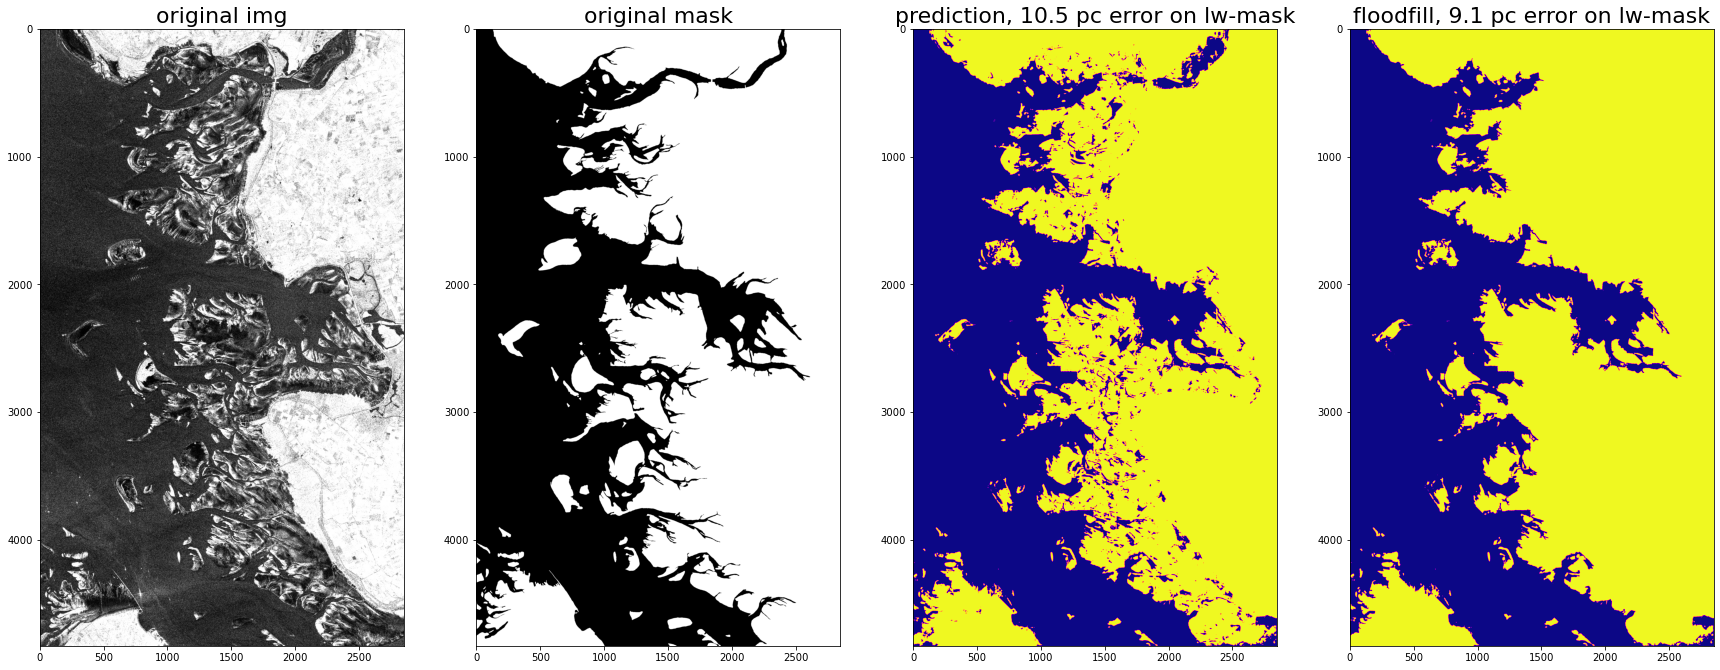

In [19]:
micro_result = torch.load('Model_params/ma1_best.pt',map_location=torch.device('cpu'))                          # load model state if no training 
macro_result = torch.load('Model_params/ma1_macro_best.pt',map_location=torch.device('cpu')) 
img_path = 'Training/image_20200108.png'
mask_path = 'Training/mask_20200108.png'
%time predict_img('20200108',img_path,mask_path,macro_result,micro_result,lw_path='Supply/lw_mask.png',show = True)

In [23]:
clear_routine([])

/home/simons/Documents/Martin
/home/simons/Documents/Martin/NN_water_lines
